In [10]:
from abc import abstractmethod

from bresenham import bresenham
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from ipykernel.pylab.backend_inline import flush_figures
from skimage import io

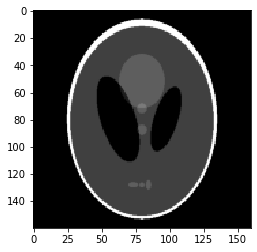

(160, 160)

In [40]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def readImage(filepath):
    return rgb2gray(mpimg.imread(filepath))

def showImage(img):
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.show()

image = readImage('tomograf-zdjecia/Kolo.jpg')
image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)
showImage(image)
image.shape

In [41]:
sinogram = None

angleSpace = np.pi / 160 
angleRange = np.pi 
numberOfDetectors = 160

In [111]:
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display
import os
from IPython.display import Image
import math

radius = circleCoords['r']      #trzeba wcześniej dodawać promień

@interact (det_num=widgets.IntSlider(min=90, max=720, step=90), alfa=widgets.IntSlider(min=10, max=180, step=10), last_first=widgets.IntSlider(min=45, max=270, step=45))
#TODO: trzeba jeszcze wcześniej wyznaczyć R 
#TODO: zmienić z wyswietlania na podstawianie odpowiednich zmiennych

def input_data(det_num, alfa, last_first):    #użytkownik podaje l. detektorow, przesuniecie alfa i rozwartosc detektorow
    print('liczba detektorow: ', det_num, '\nprzesuniecie: ', alfa, '\nrozpietosc wachlarza: ', last_first)
    
w = interactive(sinogramToResultImage, withAnimation=False, angleSpace=fixed(angleSpace), angleRange=fixed(angleRange));

@interact
def show_images(file=os.listdir('tomograf-zdjecia/')):
    display(Image('tomograf-zdjecia/' + file))

#wyswietlenie opcji animacji
#trzeba trochę poczekać, aż funkcja się cała wykona, ale ogólnie ładnie działa
display(w)

interactive(children=(IntSlider(value=90, description='det_num', max=720, min=90, step=90), IntSlider(value=10…

interactive(children=(Dropdown(description='file', options=('CT_ScoutView-large.jpg', 'CT_ScoutView.jpg', 'Kol…

interactive(children=(Checkbox(value=False, description='withAnimation'), Output()), _dom_classes=('widget-int…

In [42]:
def circleCentre(image):
    coords = list(map(lambda x: x / 2, image.shape))
    radius = (coords[0] ** 2 + coords[1] ** 2) ** 0.5
    return {'x': coords[0], 'y': coords[1], 'r': radius}

circleCoords = circleCentre(image)
circleCoords

{'x': 80.0, 'y': 80.0, 'r': 113.13708498984761}

In [43]:
def getPosition(alpha):
    x = circleCoords['x'] + circleCoords['r'] * np.cos(alpha)
    y = circleCoords['y'] + circleCoords['r'] * np.sin(alpha)
    return [int(x), int(y)]

def drawLine(emiPos, detPos):
    transitionPoints = list(bresenham(emiPos[0], emiPos[1], detPos[0], detPos[1]))
    for point in transitionPoints:
        if 0 < point[0] < image.shape[0] and 0 < point[1] < image.shape[1]:
            image[point[0], point[1]] = 255
    showImage(image)

def readValue(emiPos, detPos):
    allPoints = list(bresenham(emiPos[0], emiPos[1], detPos[0], detPos[1]))
    brightness = 0
    pixelsNum = 0
    for point in allPoints:
        if 0 < point[0] < image.shape[0] and 0 < point[1] < image.shape[1]:
            pixelsNum += 1
            brightness += image[point[0]][point[1]]
    if pixelsNum > 0:
        val = brightness / pixelsNum
        return val
    else:
        return 0

positionForSin = np.zeros((int(2 * np.pi / angleSpace), numberOfDetectors, 2, 2)) # sin[detector, emitter] -> positionForSin[det, emit]
def toSinogram(angleSpace, angleRange, numberOfDetectors):
    sin = np.zeros((int(2 * np.pi / angleSpace), numberOfDetectors))
    for emitterAngle, i in zip(np.arange(0, 2 * np.pi, angleSpace), range(int(2 * np.pi / angleSpace))):
        emitterPosition = getPosition(emitterAngle)
        for detectorAngle, j in zip(np.arange(emitterAngle + np.pi - angleRange / 2, emitterAngle + np.pi + angleRange / 2, angleRange / numberOfDetectors), range(numberOfDetectors)):
            detectorPosition = getPosition(detectorAngle)
            sin[i][j] = readValue(emitterPosition, detectorPosition)
            positionForSin[i][j] = [detectorPosition, emitterPosition]
            #drawLine(emitterPosition, detectorPosition)
    return sin, positionForSin
            
sinogram, positionForSin = toSinogram(angleSpace, angleRange, numberOfDetectors)

In [44]:
positionForSin[0][0]
#positionForSin[1][0]

array([[ 80., 193.],
       [193.,  80.]])

In [45]:
np.amax(sinogram)

0.4098370924630929

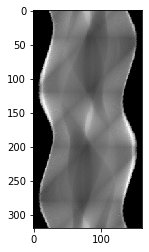

In [46]:
"""def makeSinogram3D(sinogram):
    sinogram_3d = np.zeros((sinogram.shape[0], sinogram.shape[1], 3))
    for i in range(sinogram.shape[0]):
        for j in range(sinogram.shape[1]):
            val = sinogram[i][j]
            sinogram_3d[i][j] = [val, val, val]
            
    return sinogram_3d
"""
#sinogram_3d = makeSinogram3D(sinogram)
showImage(sinogram)

In [47]:
resultImage = np.zeros(image.shape)
countForPoints = np.zeros(image.shape)
resultStepByStep = [np.zeros(image.shape)]
countForPointsStepByStep = [np.zeros(image.shape)]

def normalizeStep(step):
    for x in range(len(countForPointsStepByStep[step])):
        for y in range(len(countForPointsStepByStep[step][x])):
            val = countForPointsStepByStep[step][x][y]
            if val[0] != 0:
                resultStepByStep[step][x][y] /= val
                
    return resultStepByStep

In [99]:
def addLineToResult(emiPos, detPos, value):
    
    allPoints = list(bresenham(int(emiPos[0]), int(emiPos[1]), int(detPos[0]), int(detPos[1])))
    for point in allPoints:
        if 0 <= point[0] < image.shape[0] and 0 <= point[1] < image.shape[1]:
            countForPoints[point[0]][point[1]] += 1
            resultImage[point[0]][point[1]] += value
      
    return countForPoints, resultImage

True


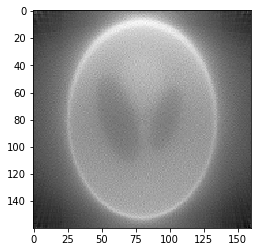

In [101]:
def on_change(resultStepByStep, x=0):
    io.imshow(resultStepByStep[x])
    flush_figures()


def sinogramToResultImage(angleSpace, angleRange, withAnimation=True):   
    print(withAnimation)  
    for i in range(sinogram.shape[0]):
        for j in range(sinogram.shape[1]):
            emitterPosition = positionForSin[i][j][1]
            detectorPosition = positionForSin[i][j][0]
            countForPoints, resultImage = addLineToResult(emitterPosition, detectorPosition, sinogram[i][j])
        
        
        '''#TODO
        
        if withAnimation:
            val = resultImage[i]
            resultStepByStep.append(val)
            normalizeStep(i)
            countForPointsStepByStep.append(countForPoints.copy())
        if withAnimation:
            print(resultStepByStep)
            widgets.interact(on_change(resultStepByStep), x=(0,len(resultStepByStep) - 1, 1))   '''  
            
                      
sinogramToResultImage(angleSpace, angleRange)
showImage(resultImage)

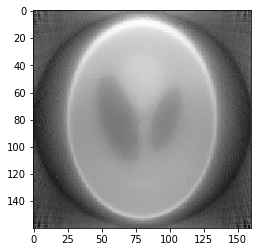

In [102]:
def divideByCountForPoints(resultImage):
    for i in range(resultImage.shape[0]):
        for j in range(resultImage.shape[1]):
            if countForPoints[i][j] != 0:
                resultImage[i][j] /= countForPoints[i][j]
            else:
                resultImage[i][j] = 0
                
    return resultImage
                
resultImage = divideByCountForPoints(resultImage)
showImage(resultImage)

In [52]:
#np.amin(resultImage)

In [53]:
'''mn = 255 / np.amax(resultImage)
odc = np.amin(resultImage)

for i in range(resultImage.shape[0]):
    for j in range(resultImage.shape[1]):
        val = resultImage[i][j]
        n_val = val - odc
        resultImage[i][j] = n_val
        
for i in range(resultImage.shape[0]):
    for j in range(resultImage.shape[1]):
        val = resultImage[i][j]
        n_val = val*mn
        resultImage[i][j] = n_val
'''

'mn = 255 / np.amax(resultImage)\nodc = np.amin(resultImage)\n\nfor i in range(resultImage.shape[0]):\n    for j in range(resultImage.shape[1]):\n        val = resultImage[i][j]\n        n_val = val - odc\n        resultImage[i][j] = n_val\n        \nfor i in range(resultImage.shape[0]):\n    for j in range(resultImage.shape[1]):\n        val = resultImage[i][j]\n        n_val = val*mn\n        resultImage[i][j] = n_val\n'

# Dla sprawdzenia - przy użyciu gotowych funkcji

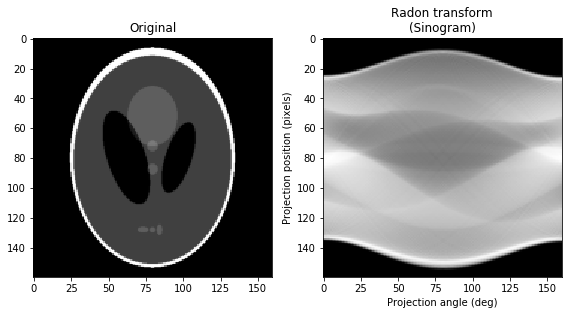

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

image = shepp_logan_phantom()
image = rescale(image, scale=0.4, mode='reflect', multichannel=False)
#image = readImage('tomograf-zdjecia/Kolo.jpg')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4.5))

ax1.set_title("Original")
ax1.imshow(image, cmap=plt.cm.Greys_r)

theta = np.linspace(0., 180., max(image.shape), endpoint=False)
sinogram = radon(image, theta=theta, circle=True)
ax2.set_title("Radon transform\n(Sinogram)")
ax2.set_xlabel("Projection angle (deg)")
ax2.set_ylabel("Projection position (pixels)")
"""ax2.imshow(sinogram, cmap=plt.cm.Greys_r,
           extent=(0, 180, 0, sinogram.shape[0]), aspect='auto')"""
ax2.imshow(sinogram, cmap=plt.cm.Greys_r)

fig.tight_layout()
plt.show()